In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="6"

Wed Jan 17 17:53:46 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   33C    P0    43W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.uniform_prior import Prior
from model.latent.mmd_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 3
hp.out_dim = 3
hp.z_dim = 128
hp.h_dims = [32, 64, 128, 256, 512]
hp.activation = F.sigmoid
hp.opts = {'pz_scale': 1,
           'mmd_kernel': 'IMQ', # 'IMQ', 'RBF'
            'pz': 'uniform', # 'normal', 'sphere', 'uniform'
            'zdim': hp.z_dim
           }

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(10):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.99169921875
encoder.convs 5.9912109375
encoder.linear 1.00048828125
prior 0.0
latent 0.0
decoder 7.028697967529297
decoder.linear 1.0078125
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_celeba/train01.17-6/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 0


### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

test_transforms = transforms.Compose([transforms.CenterCrop(148),
                                      transforms.Resize(hp.size),
                                      transforms.ToTensor(),])
test_dataset = MyCelebA(root, split='test', transform=test_transforms, download=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

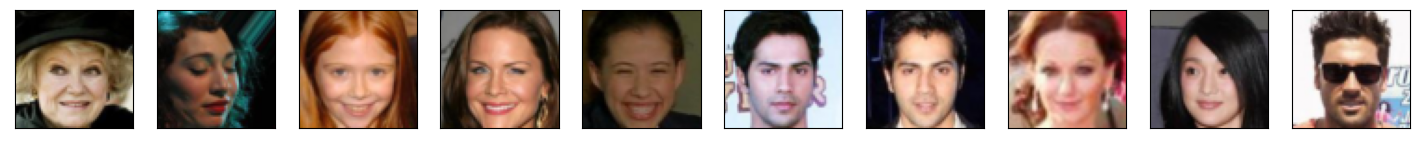

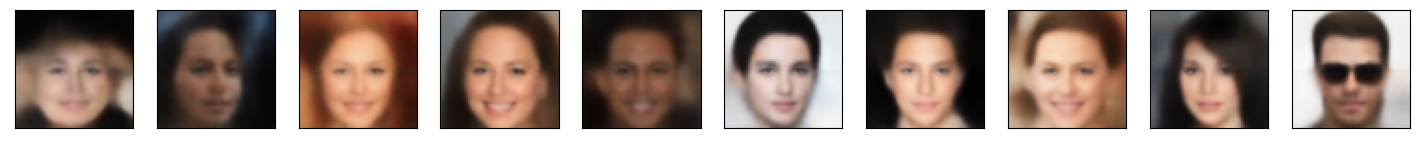

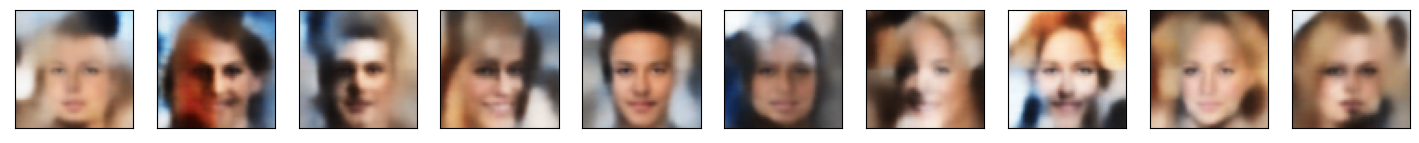

9001
mmd_loss 0.004533201456069946
recon_loss 0.009701509773731232
9002
mmd_loss 0.0035417705774307253
recon_loss 0.009631980583071709
9003
mmd_loss 0.004558390378952027
recon_loss 0.009822222497314214
9004
mmd_loss 0.005019840598106384
recon_loss 0.00931116109713912
9005
mmd_loss 0.0036236435174942017
recon_loss 0.009400503244251013
9006
mmd_loss 0.004589161276817322
recon_loss 0.008467703685164451
9007
mmd_loss 0.004181313514709473
recon_loss 0.00927555002272129
9008
mmd_loss 0.00377269983291626
recon_loss 0.009365346375852823
9009
mmd_loss 0.004749280214309692
recon_loss 0.010019058268517256
9010
mmd_loss 0.003599405288696289
recon_loss 0.00939410189166665
9011
mmd_loss 0.005262327194213867
recon_loss 0.009068053867667913
9012
mmd_loss 0.004128357768058777
recon_loss 0.009259238932281732
9013
mmd_loss 0.005610421299934387
recon_loss 0.009596596285700799
9014
mmd_loss 0.0045214414596557615
recon_loss 0.010256924573332072
9015
mmd_loss 0.0037963718175888063
recon_loss 0.00949129182845

9124
mmd_loss 0.0039460182189941405
recon_loss 0.009594260528683663
9125
mmd_loss 0.0029131531715393066
recon_loss 0.00966478418558836
9126
mmd_loss 0.0044652998447418215
recon_loss 0.009528940916061402
9127
mmd_loss 0.0033046603202819824
recon_loss 0.009800985362380743
9128
mmd_loss 0.003731444478034973
recon_loss 0.00977198090404272
9129
mmd_loss 0.0036985218524932862
recon_loss 0.009373354353010654
9130
mmd_loss 0.004274597764015198
recon_loss 0.0094868965446949
9131
mmd_loss 0.0036176234483718873
recon_loss 0.009533098712563515
9132
mmd_loss 0.004178979992866516
recon_loss 0.009945239312946797
9133
mmd_loss 0.004278406500816345
recon_loss 0.009402266517281533
9134
mmd_loss 0.0031107097864151003
recon_loss 0.009387816861271858
9135
mmd_loss 0.0036545604467391967
recon_loss 0.009988285973668099
9136
mmd_loss 0.00467233955860138
recon_loss 0.009227125160396098
9137
mmd_loss 0.003933238983154297
recon_loss 0.009357651602476836
9138
mmd_loss 0.003363862633705139
recon_loss 0.00928718084

9247
mmd_loss 0.0033139467239379885
recon_loss 0.009330318961292505
9248
mmd_loss 0.002958780527114868
recon_loss 0.009411649964749812
9249
mmd_loss 0.004500198364257813
recon_loss 0.009723475202918053
9250
mmd_loss 0.00356447696685791
recon_loss 0.009692953247576953
9251
mmd_loss 0.005479058623313904
recon_loss 0.00938475513830781
9252
mmd_loss 0.004040795564651489
recon_loss 0.009149932488799094
9253
mmd_loss 0.00582728385925293
recon_loss 0.009748235438019037
9254
mmd_loss 0.004344102740287781
recon_loss 0.009927969053387642
9255
mmd_loss 0.004237094521522522
recon_loss 0.009028442297130823
9256
mmd_loss 0.004122963547706604
recon_loss 0.009684833232313395
9257
mmd_loss 0.0038022786378860475
recon_loss 0.009290605410933494
9258
mmd_loss 0.00427839457988739
recon_loss 0.00898472461849451
9259
mmd_loss 0.003935042023658753
recon_loss 0.009534157067537307
9260
mmd_loss 0.004731503129005432
recon_loss 0.009324733633548021
9261
mmd_loss 0.004913613200187683
recon_loss 0.00956365773454308

9370
mmd_loss 0.003241690993309021
recon_loss 0.00956014422699809
9371
mmd_loss 0.00336853563785553
recon_loss 0.010287876799702644
9372
mmd_loss 0.003456208109855652
recon_loss 0.009530316200107336
9373
mmd_loss 0.004112988710403442
recon_loss 0.00947939995676279
9374
mmd_loss 0.004071426391601562
recon_loss 0.009046875778585673
9375
mmd_loss 0.0036497950553894044
recon_loss 0.009548849239945412
9376
mmd_loss 0.003185749053955078
recon_loss 0.008940283674746752
9377
mmd_loss 0.003715762495994568
recon_loss 0.009240090567618608
9378
mmd_loss 0.0036215811967849733
recon_loss 0.009771963022649289
9379
mmd_loss 0.003908371925354004
recon_loss 0.009356280788779259
9380
mmd_loss 0.004238519072532654
recon_loss 0.00940784802660346
9381
mmd_loss 0.004382979869842529
recon_loss 0.009523499943315982
9382
mmd_loss 0.003886038064956665
recon_loss 0.009292618185281754
9383
mmd_loss 0.0033014506101608277
recon_loss 0.009769815485924482
9384
mmd_loss 0.004965564608573914
recon_loss 0.009413275588303

9493
mmd_loss 0.0036339640617370607
recon_loss 0.009279732499271632
9494
mmd_loss 0.003305497765541077
recon_loss 0.00953641440719366
9495
mmd_loss 0.004562863707542419
recon_loss 0.00938107119873166
9496
mmd_loss 0.0039166569709777836
recon_loss 0.009672866947948933
9497
mmd_loss 0.0046876311302185055
recon_loss 0.009165227320045233
9498
mmd_loss 0.004020741581916809
recon_loss 0.009179933555424213
9499
mmd_loss 0.003869476914405823
recon_loss 0.009777991659939289
9500
mmd_loss 0.004079553484916687
recon_loss 0.00951241860166192
9501
mmd_loss 0.0036328673362731934
recon_loss 0.009172100108116865
9502
mmd_loss 0.004394137859344482
recon_loss 0.009493283927440643
9503
mmd_loss 0.004713982343673706
recon_loss 0.009345673769712449
9504
mmd_loss 0.0044854491949081424
recon_loss 0.00962878530845046
9505
mmd_loss 0.003880995512008667
recon_loss 0.009231510479003191
9506
mmd_loss 0.004726442694664002
recon_loss 0.009260883368551732
9507
mmd_loss 0.004014647006988526
recon_loss 0.0093952505849

9616
mmd_loss 0.004071515798568725
recon_loss 0.009044480696320533
9617
mmd_loss 0.0038439899682998655
recon_loss 0.009808413870632648
9618
mmd_loss 0.0038559108972549437
recon_loss 0.009193893242627382


In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=len(data['x']))

            # Backward
            loss = 0
            for key in data.keys():
                if 'kl_loss' in key:
                    loss = loss + data[key] * 0.00025
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=len(data['x']))
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = model.prior.sample(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        